In [1]:
 import pandas as pd
import re

# =======================
# Step 0: Load the Dataset
# =======================

train_path = "/kaggle/input/iml-challenge-2-russian-cities-housing-challenge/train/train.csv"
test_path  = "/kaggle/input/iml-challenge-2-russian-cities-housing-challenge/test/test.csv"

df_train = pd.read_csv(train_path)
df_test  = pd.read_csv(test_path)

print("Train shape:", df_train.shape)
print("Test shape:", df_test.shape)


# =================================
# Step 0 (continued): Clean Columns
# =================================

def clean_columns(df):
    cleaned = []
    for col in df.columns:
        col_new = col.strip()                    # remove leading/trailing spaces
        col_new = col_new.lower()                # lowercase
        col_new = re.sub(r"[^0-9a-zA-Z_]+", "_", col_new)  # replace special chars
        col_new = re.sub(r"_+", "_", col_new)    # collapse multiple __ to _
        col_new = col_new.strip("_")             # remove underscores at ends
        cleaned.append(col_new)
    df.columns = cleaned
    return df

df_train = clean_columns(df_train)
df_test = clean_columns(df_test)

print("\nSample column names after cleaning:")
print(df_train.columns[:20])


Train shape: (181507, 279)
Test shape: (77789, 278)

Sample column names after cleaning:
Index(['id', 'full_sq', 'life_sq', 'floor', 'product_type', 'sub_area',
       'green_zone_part', 'indust_part', 'children_preschool',
       'preschool_education_centers_raion', 'children_school',
       'school_education_centers_raion',
       'school_education_centers_top_20_raion', 'healthcare_centers_raion',
       'university_top_20_raion', 'sport_objects_raion',
       'additional_education_raion', 'culture_objects_top_25',
       'culture_objects_top_25_raion', 'shopping_centers_raion'],
      dtype='object')


In [2]:
import pandas as pd

# ================================
# Step 1: Missing Values Analysis
# ================================

def missing_value_summary(df, name="dataset"):
    print(f"\n===== Missing Values Summary for {name} =====")
    
    null_count = df.isna().sum()
    null_percent = (df.isna().sum() / len(df)) * 100
    
    missing_df = pd.DataFrame({
        'missing_count': null_count,
        'missing_percent': null_percent
    })
    
    # Show only columns with missing values
    missing_df = missing_df[missing_df['missing_count'] > 0]
    
    if missing_df.empty:
        print("No missing values found.")
    else:
        # Sort by % missing
        missing_df = missing_df.sort_values(by='missing_percent', ascending=False)
        display(missing_df.head(25))        # Show top 25
    
    return missing_df


# Run missing value summaries
train_missing = missing_value_summary(df_train, "TRAIN")
test_missing  = missing_value_summary(df_test, "TEST")


# ======================
# Identify critical cols
# ======================

train_missing_50 = train_missing[train_missing['missing_percent'] > 50]
train_missing_80 = train_missing[train_missing['missing_percent'] > 80]

test_missing_50 = test_missing[test_missing['missing_percent'] > 50]
test_missing_80 = test_missing[test_missing['missing_percent'] > 80]

print("\n--- TRAIN: Columns with > 50% missing ---")
display(train_missing_50)

print("\n--- TRAIN: Columns with > 80% missing (drop candidates) ---")
display(train_missing_80)

print("\n--- TEST: Columns with > 50% missing ---")
display(test_missing_50)

print("\n--- TEST: Columns with > 80% missing (drop candidates) ---")
display(test_missing_80)



===== Missing Values Summary for TRAIN =====


,missing_count,missing_percent
office_sqm_5000_log,11249,6.197557
trc_sqm_5000_log,7216,3.975604
full_all_log,4023,2.216443
sport_count_5000_log,2351,1.295267
area_m_log,28,0.015426
raion_popul_log,13,0.007162



===== Missing Values Summary for TEST =====


,missing_count,missing_percent
office_sqm_5000_log,4915,6.318374
trc_sqm_5000_log,3106,3.992852
full_all_log,1755,2.256103
sport_count_5000_log,994,1.277816
area_m_log,21,0.026996
raion_popul_log,12,0.015426



--- TRAIN: Columns with > 50% missing ---


,missing_count,missing_percent



--- TRAIN: Columns with > 80% missing (drop candidates) ---


,missing_count,missing_percent



--- TEST: Columns with > 50% missing ---


,missing_count,missing_percent



--- TEST: Columns with > 80% missing (drop candidates) ---


,missing_count,missing_percent


In [4]:
import pandas as pd
import numpy as np

# =======================================
# STEP 2: Identify Feature Types
# =======================================

def identify_feature_types(df):
    feature_info = {}

    # Basic groups by dtype
    num_features = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
    cat_features = df.select_dtypes(include=['object']).columns.tolist()
    bool_features = df.select_dtypes(include=['bool']).columns.tolist()
    datetime_features = df.select_dtypes(include=['datetime64']).columns.tolist()

    # Detect object columns that are actually numeric
    object_numeric = []
    for col in cat_features:
        try:
            df[col].astype(float)
            object_numeric.append(col)
        except:
            pass

    # Remove them from cat_features and add to numeric
    for col in object_numeric:
        cat_features.remove(col)
        num_features.append(col)

    # Detect integer columns that should be categorical (few unique values)
    int_categorical = []
    for col in num_features:
        if df[col].dtype in ['int64'] and df[col].nunique() < 20:
            int_categorical.append(col)

    # Detect high-cardinality categorical features
    high_cardinality = [col for col in cat_features if df[col].nunique() > 50]

    feature_info['num_features'] = num_features
    feature_info['cat_features'] = cat_features
    feature_info['bool_features'] = bool_features
    feature_info['datetime_features'] = datetime_features
    feature_info['object_numeric'] = object_numeric
    feature_info['int_categorical'] = int_categorical
    feature_info['high_cardinality'] = high_cardinality

    return feature_info


# Run feature identification for TRAIN (test will have same schema)
feature_info = identify_feature_types(df_train)

print("===== STEP 2 SUMMARY =====")

print("\nNumeric Features:", len(feature_info['num_features']))
print("Categorical Features:", len(feature_info['cat_features']))
print("Boolean Features:", len(feature_info['bool_features']))
print("Datetime Features:", len(feature_info['datetime_features']))
print("Object but Numeric:", feature_info['object_numeric'])
print("Integer but Categorical:", feature_info['int_categorical'])
print("High-cardinality Categorical:", feature_info['high_cardinality'][:10], "...")



===== STEP 2 SUMMARY =====

Numeric Features: 264
Categorical Features: 15
Boolean Features: 0
Datetime Features: 0
Object but Numeric: []
Integer but Categorical: ['high_floor', 'large_apartment']
High-cardinality Categorical: ['sub_area'] ...


===== TARGET SUMMARY =====
count    181507.000000
mean         14.845599
std          21.533138
min           0.392328
25%           5.303449
50%           7.186257
75%          11.781645
max         109.864990
Name: price_doc, dtype: float64

Missing values in target: 0

Skewness: 2.786814132228502
Kurtosis: 7.062885007961717


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


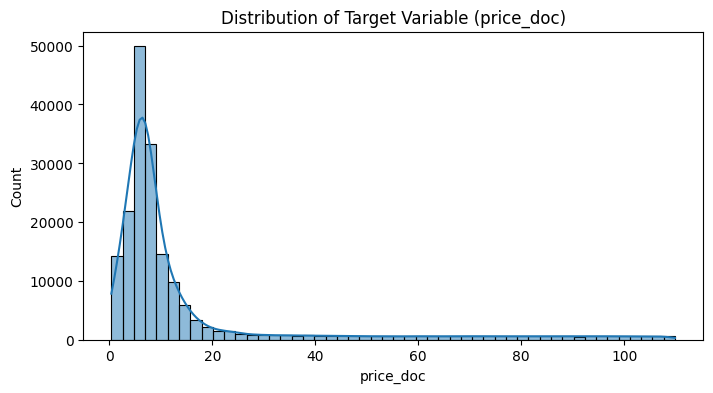

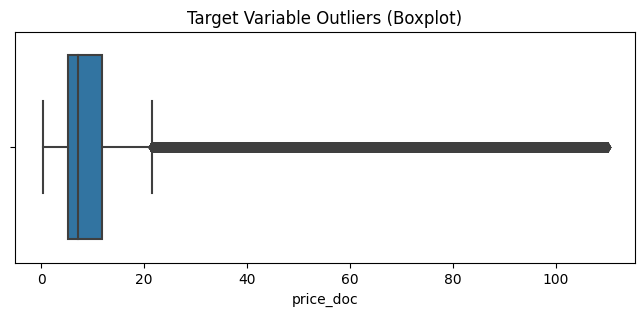


===== Target Quantiles =====
0.010      1.279856
0.050      2.074049
0.500      7.186257
0.950     73.935002
0.990    102.709418
0.999    109.169705
Name: price_doc, dtype: float64

===== Log Transform Suggestion =====
Target is highly skewed → LOG TRANSFORM RECOMMENDED (np.log1p).


In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# ================================
# STEP 3: Target Variable Analysis
# ================================

target = "price_doc"   # change this if your target name is different

# 1. Basic statistics
print("===== TARGET SUMMARY =====")
print(df_train[target].describe())

# 2. Check missing values in target
print("\nMissing values in target:", df_train[target].isna().sum())

# 3. Skewness & Kurtosis
skew_val = df_train[target].skew()
kurt_val = df_train[target].kurt()

print(f"\nSkewness: {skew_val}")
print(f"Kurtosis: {kurt_val}")

# 4. Histogram of target
plt.figure(figsize=(8,4))
sns.histplot(df_train[target], bins=50, kde=True)
plt.title("Distribution of Target Variable (price_doc)")
plt.show()

# 5. Boxplot for outliers
plt.figure(figsize=(8,3))
sns.boxplot(x=df_train[target])
plt.title("Target Variable Outliers (Boxplot)")
plt.show()

# 6. Check quantiles for outlier detection
quantiles = df_train[target].quantile([0.01, 0.05, 0.5, 0.95, 0.99, 0.999])
print("\n===== Target Quantiles =====")
print(quantiles)

# 7. Log-transform test (only print suggestion)
print("\n===== Log Transform Suggestion =====")
if skew_val > 1:
    print("Target is highly skewed → LOG TRANSFORM RECOMMENDED (np.log1p).")
elif skew_val > 0.5:
    print("Target is moderately skewed → Log transform may help but optional.")
else:
    print("Target skew is low → log transform NOT needed.")


In [6]:
import pandas as pd
import numpy as np

# ================================
# STEP 4: Numerical Feature Analysis
# ================================

numeric_features = feature_info['num_features']  # from Step 2

skew_threshold_high = 1.0
skew_threshold_mod  = 0.5
kurtosis_threshold  = 7

skew_dict = {}
kurt_dict = {}
skewed_features = []
mod_skewed_features = []
high_kurtosis_features = []

for col in numeric_features:
    skew_val = df_train[col].skew()
    kurt_val = df_train[col].kurt()
    
    skew_dict[col] = skew_val
    kurt_dict[col] = kurt_val
    
    if abs(skew_val) > skew_threshold_high:
        skewed_features.append(col)
    elif abs(skew_val) > skew_threshold_mod:
        mod_skewed_features.append(col)
        
    if abs(kurt_val) > kurtosis_threshold:
        high_kurtosis_features.append(col)

# Create DataFrame for easy viewing
num_stats = pd.DataFrame({
    'skewness': pd.Series(skew_dict),
    'kurtosis': pd.Series(kurt_dict)
}).sort_values(by='skewness', ascending=False)

print("===== Top 20 Most Skewed Features =====")
display(num_stats.head(20))

print("\nNumber of highly skewed features (|skew|>1):", len(skewed_features))
print("Number of moderately skewed features (0.5<|skew|<=1):", len(mod_skewed_features))
print("Number of high-kurtosis features (kurt>7):", len(high_kurtosis_features))

# Optional: Examine extreme values (outliers) for top skewed features
print("\n===== Quantiles for Top 5 Skewed Features =====")
for col in skewed_features[:5]:
    print(f"\nFeature: {col}")
    print(df_train[col].quantile([0.01,0.05,0.25,0.5,0.75,0.95,0.99,0.999]))


===== Top 20 Most Skewed Features =====


,skewness,kurtosis
rooms_inferred,2.994130,8.069322
life_sq,2.989646,8.045954
full_sq,2.907440,7.397158
build_count_foam,2.895906,7.504710
mosque_count_500,2.811266,6.800066
trc_sqm_500,2.787118,6.844975
price_doc,2.786814,7.062885
church_synagogue_km,2.743202,6.787126
leisure_count_500,2.726963,6.536765
leisure_count_1000,2.694443,6.356094



Number of highly skewed features (|skew|>1): 235
Number of moderately skewed features (0.5<|skew|<=1): 19
Number of high-kurtosis features (kurt>7): 7

===== Quantiles for Top 5 Skewed Features =====

Feature: full_sq
0.010      -7.129761
0.050       9.994688
0.250      36.527739
0.500      57.850524
0.750      88.740084
0.950    3560.671579
0.990    4973.729219
0.999    5287.508302
Name: full_sq, dtype: float64

Feature: life_sq
0.010     -39.731218
0.050     -17.444979
0.250      16.459273
0.500      43.590090
0.750      90.921327
0.950    4791.083057
0.990    6956.529836
0.999    7418.416100
Name: life_sq, dtype: float64

Feature: floor
0.010     0.805748
0.050     1.557372
0.250     3.846373
0.500     6.776766
0.750    11.624073
0.950    51.236744
0.990    71.802289
0.999    76.515520
Name: floor, dtype: float64

Feature: children_preschool
0.010      177.493364
0.050      402.385896
0.250     2531.043574
0.500     4826.317688
0.750     7082.143332
0.950    14051.227805
0.990    1

In [8]:
import numpy as np
import pandas as pd

# ===============================
# STEP 4 CLEANUP: Numeric Features
# ===============================

# Numeric features from Step 2
numeric_features = feature_info['num_features']  # Already defined in Step 2

# Skew threshold for high skew
skew_threshold = 1.0

# Identify highly skewed features
skewed_features = [col for col in numeric_features if abs(df_train[col].skew()) > skew_threshold]
print(f"Number of highly skewed features: {len(skewed_features)}")
print("Top 10 highly skewed features:", skewed_features[:10])

# Function to safely apply log1p, shifting negative values slightly
def safe_log1p(series, eps=1e-3):
    """Shift negative values minimally and apply log1p."""
    series = series.copy()
    min_val = series.min()
    if min_val < 0:
        series = series + abs(min_val) + eps  # shift so minimum is slightly positive
    return np.log1p(series)

# Apply safe log1p transformation to all skewed numeric features
for col in skewed_features:
    df_train[col] = safe_log1p(df_train[col])

print("\n✅ Log-transform applied safely to all highly skewed numeric features.")


Number of highly skewed features: 117
Top 10 highly skewed features: ['full_sq', 'life_sq', 'children_preschool', 'children_school', 'school_education_centers_top_20_raion', 'university_top_20_raion', 'culture_objects_top_25_raion', 'young_all', 'young_male', 'young_female']

✅ Log-transform applied safely to all highly skewed numeric features.


In [9]:
import pandas as pd

# ===============================
# STEP 5: Categorical Feature Analysis
# ===============================

cat_features = feature_info['cat_features']  # from Step 2

encoding_plan = []

for col in cat_features:
    nunique = df_train[col].nunique()
    counts = df_train[col].value_counts(normalize=True)
    rare_categories = counts[counts < 0.01].index.tolist()  # <1% of rows
    
    if nunique > 50:
        enc_type = "LabelEncoding (high-cardinality)"
    else:
        enc_type = "OneHotEncoding (low-cardinality)"
    
    encoding_plan.append({
        'feature': col,
        'nunique': nunique,
        'rare_categories_count': len(rare_categories),
        'encoding_type': enc_type
    })

encoding_df = pd.DataFrame(encoding_plan).sort_values(by='nunique', ascending=False)
display(encoding_df)


,feature,nunique,rare_categories_count,encoding_type
1,sub_area,1926,1926,LabelEncoding (high-cardinality)
14,ecology,5,0,OneHotEncoding (low-cardinality)
0,product_type,2,0,OneHotEncoding (low-cardinality)
2,culture_objects_top_25,2,0,OneHotEncoding (low-cardinality)
3,thermal_power_plant_raion,2,0,OneHotEncoding (low-cardinality)
4,incineration_raion,2,0,OneHotEncoding (low-cardinality)
5,oil_chemistry_raion,2,0,OneHotEncoding (low-cardinality)
6,radiation_raion,2,0,OneHotEncoding (low-cardinality)
7,railroad_terminal_raion,2,0,OneHotEncoding (low-cardinality)
8,big_market_raion,2,0,OneHotEncoding (low-cardinality)


In [14]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder

# --- Step 5: Categorical Feature Encoding ---

# High-cardinality
high_card_cols = ['sub_area']

# Low-cardinality
low_card_cols = ['product_type', 'ecology', 'culture_objects_top_25', 
                 'thermal_power_plant_raion', 'incineration_raion', 
                 'oil_chemistry_raion', 'radiation_raion', 'railroad_terminal_raion',
                 'big_market_raion', 'nuclear_reactor_raion', 'detention_facility_raion',
                 'water_1line', 'big_road1_1line', 'railroad_1line']

# --- 1️⃣ Label Encoding for high-cardinality ---
for col in high_card_cols:
    le = LabelEncoder()
    combined = pd.concat([df_train[col], df_test[col]], axis=0).astype(str)
    le.fit(combined)
    df_train[col] = le.transform(df_train[col].astype(str))
    df_test[col] = le.transform(df_test[col].astype(str))

# --- 2️⃣ One-Hot Encoding for low-cardinality ---
# Only encode columns that exist (some may have been removed/encoded already)
low_card_existing = [c for c in low_card_cols if c in df_train.columns]

# Concatenate train + test to align columns
df_all = pd.concat([df_train, df_test], axis=0)
df_all = pd.get_dummies(df_all, columns=low_card_existing, drop_first=False)

# Split back to train/test
df_train = df_all.iloc[:df_train.shape[0], :].copy()
df_test = df_all.iloc[df_train.shape[0]:, :].copy()

print("✅ Categorical features encoded successfully.")
print(f"Train shape after encoding: {df_train.shape}")
print(f"Test shape after encoding: {df_test.shape}")


✅ Categorical features encoded successfully.
Train shape after encoding: (181507, 282)
Test shape after encoding: (77789, 282)


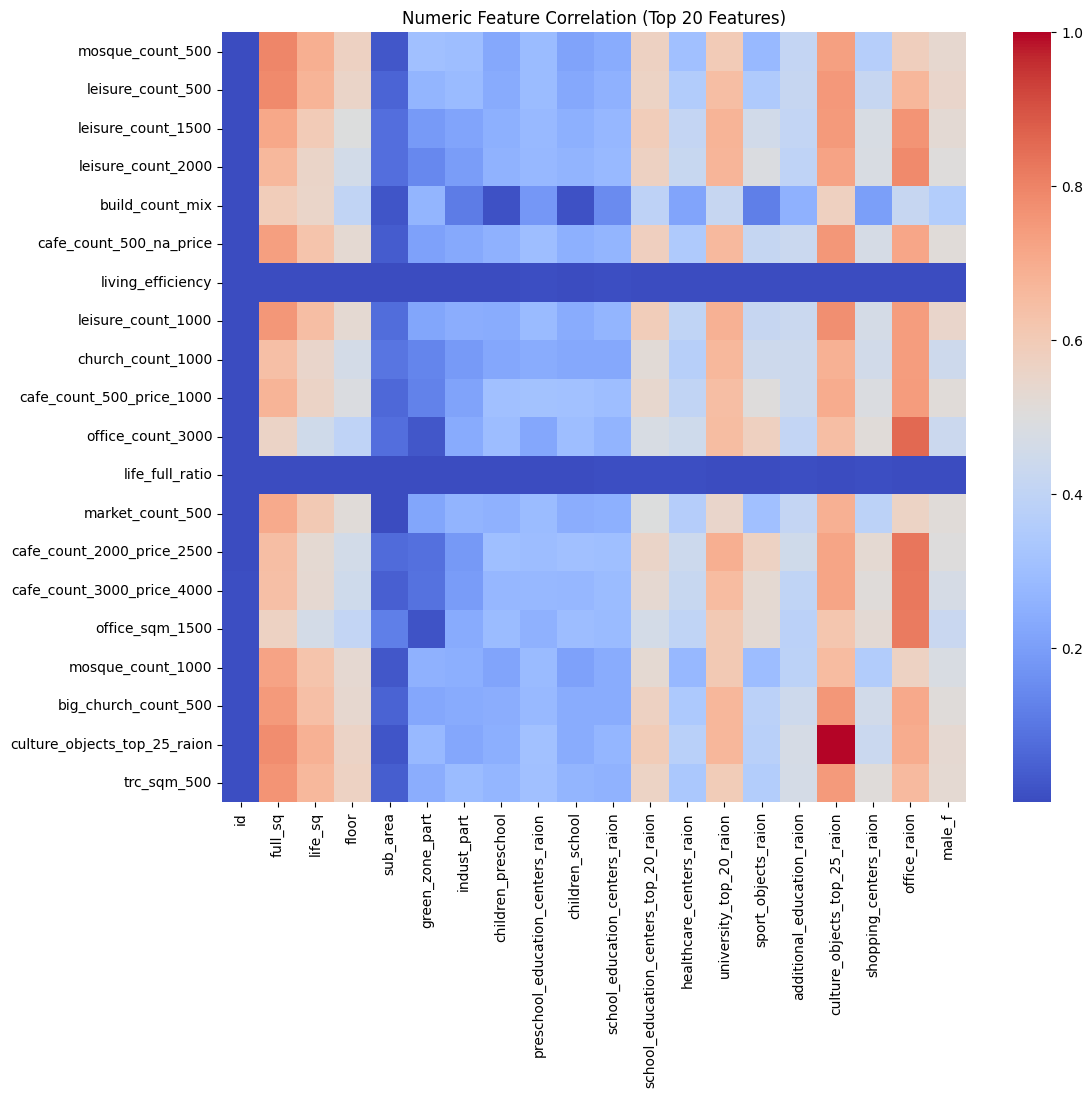

===== Top 20 Features Most Positively Correlated with Target =====
price_doc                     1.000000
full_sq                       0.651954
large_apartment               0.635516
cafe_count_1000               0.611409
cafe_count_1000_price_2500    0.610964
cafe_count_1500_price_2500    0.608101
cafe_count_1500               0.606884
cafe_count_1000_price_1500    0.606212
cafe_count_1000_price_4000    0.606141
cafe_count_1000_price_high    0.605465
cafe_count_500_price_4000     0.605140
cafe_count_1500_price_high    0.601695
cafe_count_2000               0.601145
leisure_count_500             0.600438
cafe_count_1500_price_1500    0.600023
cafe_count_1500_price_4000    0.599347
cafe_count_2000_price_2500    0.599113
leisure_count_1000            0.598771
cafe_count_500_price_2500     0.597979
cafe_count_1500_price_1000    0.595725
Name: price_doc, dtype: float64

===== Top 20 Features Most Negatively Correlated with Target =====
mosque_km                   0.138091
id_bus_terminal 

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

# Copy numeric columns only (exclude target for correlation heatmap)
numeric_cols = df_train.select_dtypes(include=np.number).columns.tolist()
if 'price_doc' in numeric_cols:
    numeric_cols.remove('price_doc')  # exclude target from numeric-numeric correlation

# 1️⃣ Correlation matrix (numeric-numeric)
corr_matrix = df_train[numeric_cols].corr()

# Plot heatmap for top correlated features (sample for visualization)
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix.abs().sort_values(by=numeric_cols[0], axis=0).iloc[:20, :20],
            annot=False, cmap='coolwarm')
plt.title("Numeric Feature Correlation (Top 20 Features)")
plt.show()

# 2️⃣ Correlation with target
target_corr = df_train[numeric_cols + ['price_doc']].corr()['price_doc'].sort_values(ascending=False)

print("===== Top 20 Features Most Positively Correlated with Target =====")
print(target_corr.head(20))

print("\n===== Top 20 Features Most Negatively Correlated with Target =====")
print(target_corr.tail(20))


In [18]:
# List of numeric columns with missing values
missing_cols = ['office_sqm_5000_log', 'trc_sqm_5000_log', 
                'full_all_log', 'sport_count_5000_log', 
                'area_m_log', 'raion_popul_log']

# Impute missing values safely (no inplace chained assignment)
for col in missing_cols:
    median_val = df_train[col].median()
    df_train[col] = df_train[col].fillna(median_val)
    df_test[col] = df_test[col].fillna(median_val)

# Verify
print("✅ Missing values after safe imputation (train):")
print(df_train[missing_cols].isna().sum())
print("\n✅ Missing values after safe imputation (test):")
print(df_test[missing_cols].isna().sum())

✅ Missing values after safe imputation (train):
office_sqm_5000_log     0
trc_sqm_5000_log        0
full_all_log            0
sport_count_5000_log    0
area_m_log              0
raion_popul_log         0
dtype: int64

✅ Missing values after safe imputation (test):
office_sqm_5000_log     0
trc_sqm_5000_log        0
full_all_log            0
sport_count_5000_log    0
area_m_log              0
raion_popul_log         0
dtype: int64


In [19]:
import numpy as np

# 1️⃣ Log-transform target (highly skewed)
df_train['price_doc_log'] = np.log1p(df_train['price_doc'])

# 2️⃣ Prepare training features and target
X_train = df_train.drop(['price_doc', 'price_doc_log'], axis=1)
y_train = df_train['price_doc_log']

# 3️⃣ Prepare test features
X_test = df_test.copy()

# 4️⃣ Verify shapes
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")

# 5️⃣ Optional: Check columns alignment
missing_cols_in_test = set(X_train.columns) - set(X_test.columns)
extra_cols_in_test = set(X_test.columns) - set(X_train.columns)
print(f"Columns missing in test: {missing_cols_in_test}")
print(f"Extra columns in test: {extra_cols_in_test}")


X_train shape: (181507, 281)
y_train shape: (181507,)
X_test shape: (77789, 282)
Columns missing in test: set()
Extra columns in test: {'price_doc'}


In [ ]:
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import numpy as np

# Feature set
X = X_train
y = y_train
X_test_final = X_test

# Train/test split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Hyperparameter grid
param_grid = {
    'n_estimators': [500, 700, 1000],
    'max_depth': [10, 15, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 5, 10],
    'max_features': ['sqrt', 'log2', 0.8, 1.0],
    'bootstrap': [False]
}

# Optimized ExtraTrees with Randomized Search
et_model = ExtraTreesRegressor(random_state=42, n_jobs=-1)

search = RandomizedSearchCV(
    estimator=et_model,
    param_distributions=param_grid,
    n_iter=30,               # number of random combinations
    scoring='neg_root_mean_squared_error',
    cv=3,
    verbose=2,
    random_state=42
)

# Fit
search.fit(X_train, y_train)

# Best parameters
best_params = search.best_params_
print(f"\n🏆 Best ExtraTrees Parameters: {best_params}")

# Validation performance
y_val_pred = search.best_estimator_.predict(X_val)
rmse_val = np.sqrt(mean_squared_error(y_val, y_val_pred))
print(f"✅ Optimized ExtraTrees RMSE on validation: {rmse_val:.4f}")

# Train on full data
final_model = search.best_estimator_
final_model.fit(X, y)

# Predict on test set
y_test_pred = final_model.predict(X_test_final)

# Save submission
submission = pd.DataFrame({
   'id': test['id'].astype(int), 
    'price_doc': y_test_pred
})
submission.to_csv("optimized_extratrees_submission.csv", index=False)
print("✅ Submission saved: optimized_extratrees_submission.csv")


Fitting 3 folds for each of 30 candidates, totalling 90 fits
[CV] END bootstrap=False, max_depth=15, max_features=0.8, min_samples_leaf=5, min_samples_split=2, n_estimators=500; total time=11.3min
[CV] END bootstrap=False, max_depth=15, max_features=0.8, min_samples_leaf=5, min_samples_split=2, n_estimators=500; total time=11.7min
